<a href="https://colab.research.google.com/github/Debayan2004/DPBH-Hackathon/blob/main/BuildingHeightestimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.1 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [ ]:
def build_generator():
    def residual_block(x):
        res = Conv2D(64, (3, 3), padding='same')(x)
        res = tf.nn.relu(res)
        res = Conv2D(64, (3, 3), padding='same')(res)
        return Add()([x, res])

    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), padding='same')(inputs)
    x = tf.nn.relu(x)

    res = residual_block(x)
    for _ in range(15):
        res = residual_block(res)

    x = Conv2D(64, (3, 3), padding='same')(res)
    x = Add()([x, res])

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = tf.nn.relu(x)

    x = UpSampling2D(size=(2, 2))(x)
    outputs = Conv2D(3, (9, 9), padding='same', activation='tanh')(x)

    return Model(inputs, outputs)

In [ ]:
def preprocess_image(image):
    image = image.astype(np.float32) / 127.5 - 1
    return image

def postprocess_image(image):
    image = ((image + 1) * 127.5).astype(np.uint8)
    return image

def load_images_from_folder(folder, target_size):
    low_res_images = []
    high_res_images = []
    filenames = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith('.tif'):
                file_path = os.path.join(root, file)
                try:
                    with rasterio.open(file_path) as src:
                        img = src.read((1, 2, 3)).transpose(1, 2, 0)
                        high_res_img = img

                        low_res_img = resize_image(high_res_img, target_size)

                        high_res_images.append(preprocess_image(high_res_img))
                        low_res_images.append(preprocess_image(low_res_img))
                        filenames.append(file)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
    return np.array(low_res_images), np.array(high_res_images), filenames


In [ ]:
def resize_image(image, target_size):
    with rasterio.Env():
        height, width, _ = image.shape
        scale_factor = target_size[0] / height  # Assuming square target size
        transform = rasterio.Affine(scale_factor, 0, 0, 0, scale_factor, 0)
        new_shape = (target_size[0], target_size[1])

        image_resized = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)

        for i in range(3):  # Iterate over bands
            band = image[:, :, i]
            with rasterio.open(
                'temp.tif', 'w', driver='GTiff', height=new_shape[0], width=new_shape[1], count=1, dtype=band.dtype, transform=transform) as dst:
                dst.write(band, 1)
            with rasterio.open('temp.tif') as src:
                band_resized = src.read(1)
            image_resized[:, :, i] = band_resized

        os.remove('temp.tif')  # Clean up the temporary file

    return image_resized
def save_image(image, filepath):
    image = postprocess_image(image)
    with rasterio.open(filepath, 'w', driver='GTiff', height=image.shape[0], width=image.shape[1], count=3, dtype=image.dtype) as dst:
        dst.write(image[:, :, 0], 1)
        dst.write(image[:, :, 1], 2)
        dst.write(image[:, :, 2], 3)

def train_gan(generator, low_res_images, high_res_images):
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator.compile(loss='mse', optimizer=optimizer)
    generator.fit(low_res_images, high_res_images, epochs=25, batch_size=8)

def super_resolve_images(generator, input_folder, output_folder, target_size):
    os.makedirs(output_folder, exist_ok=True)
    low_res_images, _, filenames = load_images_from_folder(input_folder, target_size)
    super_res_images = generator.predict(low_res_images)

    for super_res_image, filename in zip(super_res_images, filenames):
        save_image(super_res_image, os.path.join(output_folder, filename))

In [ ]:
# Directories
input_folders = ['/content/drive/MyDrive/Height_Estimation_Images/sentinal 2/s2chinares_check', '/content/drive/MyDrive/Height_Estimation_Images/sentinal 2/s2eures_check', '/content/drive/MyDrive/Height_Estimation_Images/sentinal 2/s2usares_check']
output_folders = ['/content/drive/MyDrive/Height_Estimation_Images/content/HR_china', '/content/drive/MyDrive/Height_Estimation_Images/content/HR_eu', '/content/drive/MyDrive/Height_Estimation_Images/content/HR_usa']

In [ ]:
# Build the generator model
generator = build_generator()

In [ ]:
# Load images and split into training and testing sets
low_res_images, high_res_images, _ = [], [], []

for input_folder in input_folders:
    lr_images, hr_images, _ = load_images_from_folder(input_folder, target_size=(64, 64))
    low_res_images.extend(lr_images)
    high_res_images.extend(hr_images)

low_res_images = np.array(low_res_images)
high_res_images = np.array(high_res_images)

X_train_lr, X_test_lr, X_train_hr, X_test_hr = train_test_split(low_res_images, high_res_images, test_size=0.2, random_state=42)

# Train the GAN
train_gan(generator, X_train_lr, X_train_hr)

# Generate high-resolution images for test set
for input_folder, output_folder in zip(input_folders, output_folders):
    super_resolve_images(generator, input_folder, output_folder, target_size=(256, 256))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/25
900/900 [==============================] - 17456s 19s/step - loss: 42.8805
Epoch 2/25
152/900 [====>.........................] - ETA: 4:01:56 - loss: 45.4449

Visualizing image from /content/drive/MyDrive/Height_Estimation_Images/Building_height


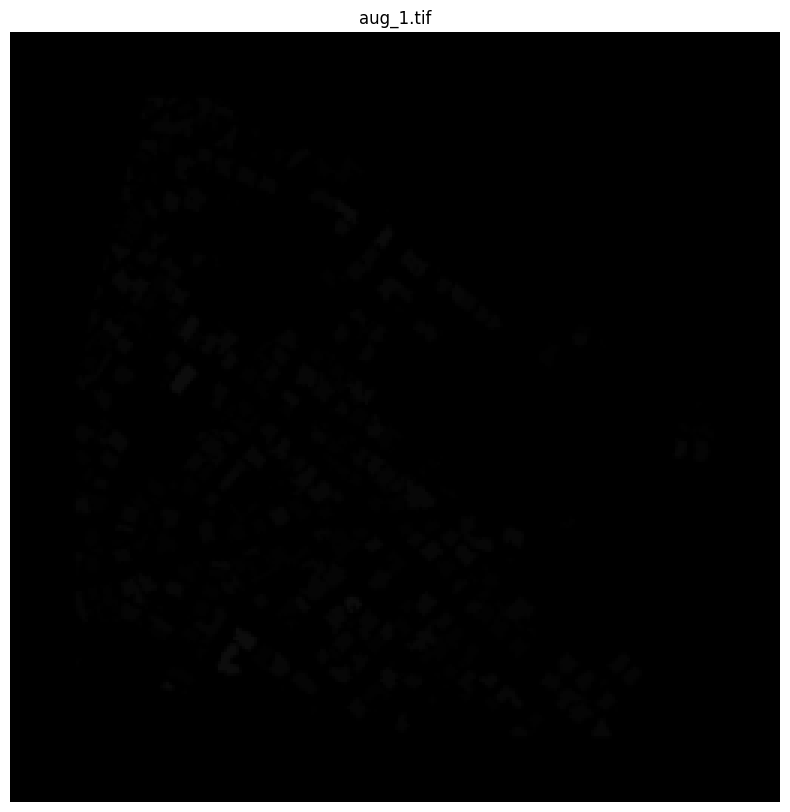

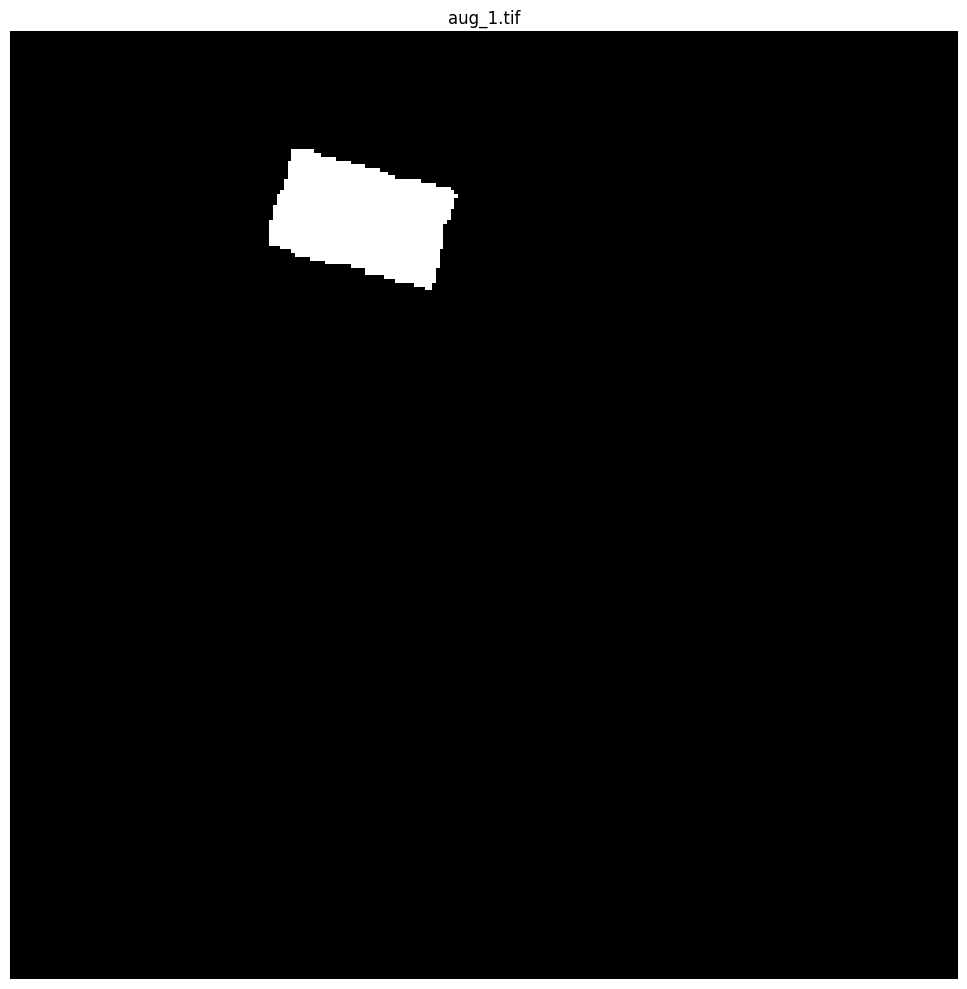

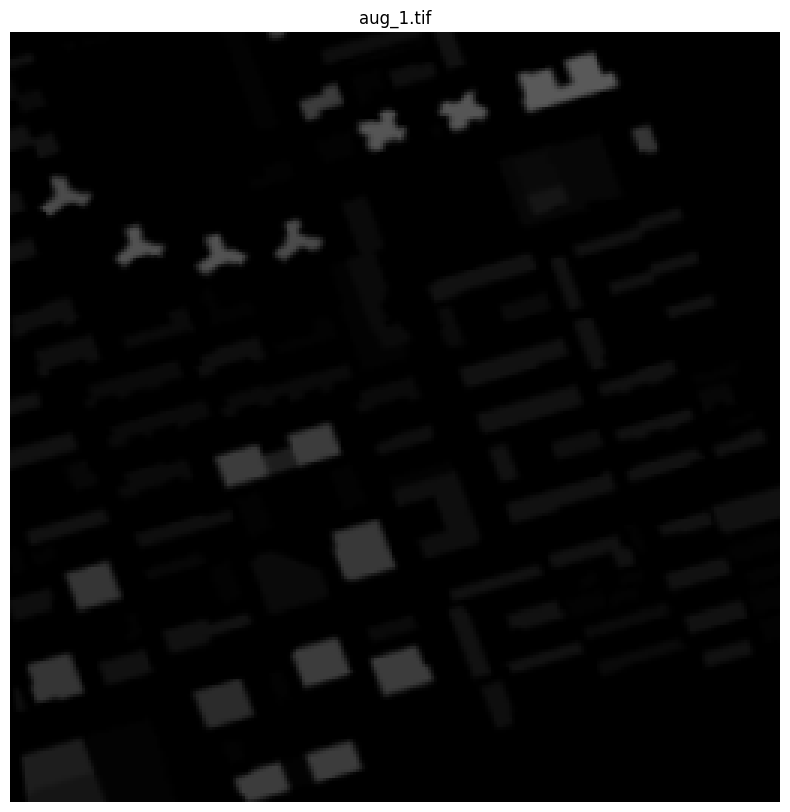

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def get_image_paths(folder_path, image_name):
    """Get paths of images with the given name from all subfolders in the main folder."""
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file == image_name:
                image_paths.append(os.path.join(root, file))
    return image_paths

def visualize_image(image_path):
    """Visualize the image using rasterio and matplotlib."""
    try:
        with rasterio.open(image_path) as src:
            # Check number of bands in the image
            num_bands = src.count

            if num_bands >= 3:
                # Read RGB bands (assuming bands 1, 2, and 3)
                r = src.read(1)
                g = src.read(2)
                b = src.read(3)
                rgb_image = np.stack([r, g, b], axis=-1)
                plt.figure(figsize=(10, 10))
                plt.imshow(rgb_image)
            else:
                # Read available bands and visualize them as grayscale
                images = [src.read(i) for i in range(1, num_bands + 1)]
                fig, axes = plt.subplots(1, num_bands, figsize=(10, 10))
                if num_bands == 1:
                    axes = [axes]
                for ax, img, band in zip(axes, images, range(1, num_bands + 1)):
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f'Band {band}')
                    ax.axis('off')
                plt.tight_layout()

        plt.title(os.path.basename(image_path))
        plt.axis('off')  # Turn off axis labels
        plt.show()

    except Exception as e:
        print(f"Error visualizing image '{os.path.basename(image_path)}': {str(e)}")

def main():
    base_folder = '/content/drive/MyDrive/Height_Estimation_Images'  # Replace with your base folder path
    image_name = 'aug_1.tif'     # Replace with your specific image name

    folders = ['Building_height']

    for folder in folders:
        folder_path = os.path.join(base_folder, folder)
        image_paths = get_image_paths(folder_path, image_name)
        if image_paths:
            print(f"Visualizing image from {folder_path}")
            for image_path in image_paths:
                visualize_image(image_path)

if __name__ == "__main__":
    main()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Custom Dataset class
class SentinelDataset(Dataset):
    def __init__(self, sentinel1_paths, sentinel2_paths, transform=None):
        self.sentinel1_paths = sentinel1_paths
        self.sentinel2_paths = sentinel2_paths
        self.transform = transform

    def __len__(self):
        return len(self.sentinel1_paths)

    def __getitem__(self, idx):
        s1_path = self.sentinel1_paths[idx]
        s2_path = self.sentinel2_paths[idx]

        with rasterio.open(s1_path) as src1:
            s1_img = src1.read(1, out_dtype=np.float32)  # Read only the first band

        with rasterio.open(s2_path) as src2:
            s2_img = src2.read(1, out_dtype=np.float32)  # Read only the first band

        # Add a channel dimension
        s1_img = np.expand_dims(s1_img, axis=0)
        s2_img = np.expand_dims(s2_img, axis=0)

        sample = {'sentinel1': s1_img, 'sentinel2': s2_img}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Transform class to convert to tensor and normalize
class ToTensor(object):
    def __call__(self, sample):
        s1_img, s2_img = sample['sentinel1'], sample['sentinel2']
        s1_img = s1_img.astype(np.float32)
        s2_img = s2_img.astype(np.float32)
        return {'sentinel1': torch.from_numpy(s1_img),
                'sentinel2': torch.from_numpy(s2_img)}

# Define the model
class HeightEstimationModel(nn.Module):
    def __init__(self):
        super(HeightEstimationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1),  # Adjust input channels to 2 (1 from Sentinel-1 + 1 from Sentinel-2)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        )

        self.hr_fuse1 = nn.Conv2d(2, 1, kernel_size=1)
        self.hr_fuse2 = nn.Conv2d(2, 1, kernel_size=1)

    def forward(self, s1, s2):
        x = torch.cat((s1, s2), dim=1)
        encoded = self.encoder(x)

        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)

        hr_fuse_input1 = torch.cat((decoded1, s1[:, 0:1, :, :]), dim=1)
        hr_fuse_output1 = self.hr_fuse1(hr_fuse_input1)

        hr_fuse_input2 = torch.cat((decoded2, s1[:, 0:1, :, :]), dim=1)
        hr_fuse_output2 = self.hr_fuse2(hr_fuse_input2)

        return decoded1, hr_fuse_output1, decoded2, hr_fuse_output2

# Example function to train the model
def train_model(model, dataloader, criterion_mse, criterion_ce, criterion_dice, optimizer, num_epochs=25, save_path='height_estimation_model.pth'):
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            s1 = data['sentinel1']
            s2 = data['sentinel2']

            optimizer.zero_grad()

            decoded1, hr_fuse_output1, decoded2, hr_fuse_output2 = model(s1, s2)

            # Define your target tensors
            target_height = torch.rand_like(decoded1)  # Placeholder for actual target
            target_class = torch.randint(0, 2, decoded2.size()).float()  # Placeholder for actual target

            loss_mse = criterion_mse(decoded1, target_height)  # Loss for height estimation
            loss_ce = criterion_ce(decoded2, target_class)  # Loss for height level classification
            loss_dice = criterion_dice(decoded2, target_class)  # Dice loss for height level classification

            loss = loss_mse + loss_ce + loss_dice

            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

        # Save the model after every epoch
        torch.save(model.state_dict(), save_path)
        print(f"Model saved after epoch {epoch+1}")

    # Save the final model
    torch.save(model.state_dict(), save_path)
    print("Final model saved")

# Dice Loss Function
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

# Data preparation
def get_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.tif'):
                image_paths.append(os.path.join(root, file))
    return sorted(image_paths)

base_folder = '/content/drive/MyDrive/Height_Estimation_Images'
sentinel1_paths = get_image_paths(os.path.join(base_folder, 'Sentinal 1'))
sentinel2_paths = get_image_paths(os.path.join(base_folder, 'sentinal 2'))

# Check and debug
print(f"Number of Sentinel-1 images: {len(sentinel1_paths)}")
print(f"Number of Sentinel-2 images: {len(sentinel2_paths)}")

# Ensure the same order of images
assert len(sentinel1_paths) == len(sentinel2_paths), "Mismatch in the number of images"

dataset = SentinelDataset(sentinel1_paths, sentinel2_paths, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model with the correct number of input channels
model = HeightEstimationModel()

# Loss functions and optimizer
criterion_mse = nn.MSELoss()  # Loss function for height estimation
criterion_ce = nn.BCEWithLogitsLoss()  # Loss function for classification (binary cross-entropy)
criterion_dice = dice_loss  # Dice loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader, criterion_mse, criterion_ce, criterion_dice, optimizer, num_epochs=10, save_path='height_estimation_model.pth')


Number of Sentinel-1 images: 9000
Number of Sentinel-2 images: 9000
Epoch [1/25], Step [1/2250], Loss: 42.45527267456055
Epoch [1/25], Step [11/2250], Loss: 1.769150733947754
Epoch [1/25], Step [21/2250], Loss: 1.6920883655548096
Epoch [1/25], Step [31/2250], Loss: 1.4054218530654907
Epoch [1/25], Step [41/2250], Loss: 1.4371997117996216
Epoch [1/25], Step [51/2250], Loss: 1.4610017538070679
Epoch [1/25], Step [61/2250], Loss: 1.5095185041427612
Epoch [1/25], Step [71/2250], Loss: 1.3850021362304688
Epoch [1/25], Step [81/2250], Loss: 1.3939313888549805
Epoch [1/25], Step [91/2250], Loss: 1.3148809671401978
Epoch [1/25], Step [101/2250], Loss: 1.368506908416748
Epoch [1/25], Step [111/2250], Loss: 1.2676496505737305
Epoch [1/25], Step [121/2250], Loss: 1.3329668045043945
Epoch [1/25], Step [131/2250], Loss: 1.293060541152954
Epoch [1/25], Step [141/2250], Loss: 1.2896721363067627
Epoch [1/25], Step [151/2250], Loss: 1.3093152046203613
Epoch [1/25], Step [161/2250], Loss: 1.327135562896

In [ ]:
import os
import torch
import torch.nn as nn
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

# Custom Dataset class
class BuildingHeightDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            with rasterio.open(img_path) as src:
                # Read the first band only
                img = src.read(1)
        except rasterio.errors.RasterioIOError:
            # Skip the file if it's not readable
            return None

        # Ensure the image has the expected shape (1, 256, 256)
        img = np.expand_dims(img, axis=0)  # Add channel dimension

        sample = {'image': img}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Custom DataLoader to handle None values
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Transform class to convert to tensor and normalize
class ToTensor(object):
    def __call__(self, sample):
        img = sample['image'].astype(np.float32)
        return {'image': torch.from_numpy(img)}

# Define the model
class HeightEstimationModel(nn.Module):
    def __init__(self):
        super(HeightEstimationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Adjusted for 1 input channel
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        )

        self.hr_fuse1 = nn.Conv2d(2, 1, kernel_size=1)
        self.hr_fuse2 = nn.Conv2d(2, 1, kernel_size=1)

    def forward(self, x):
        encoded = self.encoder(x)

        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)

        hr_fuse_input1 = torch.cat((decoded1, x), dim=1)  # Assuming x is single-channel input
        hr_fuse_output1 = self.hr_fuse1(hr_fuse_input1)

        hr_fuse_input2 = torch.cat((decoded2, x), dim=1)  # Assuming x is single-channel input
        hr_fuse_output2 = self.hr_fuse2(hr_fuse_input2)

        return decoded1, hr_fuse_output1, decoded2, hr_fuse_output2

# Dice Loss Function
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

# Load images from folder
def load_image_paths(base_folder):
    image_paths = []
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.tif'):
                image_paths.append(os.path.join(root, file))
    return sorted(image_paths)

# Apply uncertainty weighting
def uncertainty_weighting(loss_mse, loss_ce, loss_dice):
    # Placeholder for the actual uncertainty weighting
    # Implement the method to calculate weights based on uncertainty
    weight_mse = 1.0  # Example weights
    weight_ce = 1.0
    weight_dice = 1.0

    total_loss = weight_mse * loss_mse + weight_ce * loss_ce + weight_dice * loss_dice
    return total_loss

# Evaluate the model
def evaluate_model(model, dataloader, criterion_mse, criterion_ce, criterion_dice):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            images = data['image']
            decoded1, hr_fuse_output1, decoded2, hr_fuse_output2 = model(images)

            # Define your target tensors for testing
            target_height = torch.rand_like(decoded1)  # Placeholder for actual target
            target_class = torch.randint(0, 2, decoded2.size()).float()  # Placeholder for actual target

            loss_mse = criterion_mse(decoded1, target_height)
            loss_ce = criterion_ce(decoded2, target_class)
            loss_dice = criterion_dice(decoded2, target_class)

            loss = uncertainty_weighting(loss_mse, loss_ce, loss_dice)

            print(f"Test Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

def main():
    base_folder = '/content/drive/MyDrive/Height_Estimation_Images/Building_height'
    image_paths = load_image_paths(base_folder)

    dataset = BuildingHeightDataset(image_paths, transform=ToTensor())
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model, loss function, optimizer
    model = HeightEstimationModel()
    criterion_mse = nn.MSELoss()  # Loss function for height estimation
    criterion_ce = nn.BCEWithLogitsLoss()  # Loss function for classification (binary cross-entropy)
    criterion_dice = dice_loss  # Dice loss for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Uncomment the following lines to train the model
    # train_model(model, train_loader, criterion_mse, criterion_ce, criterion_dice, optimizer, num_epochs=10)

    # Save the model after training
    model_path = '/content/drive/MyDrive/Height_Estimation_Images/model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Load the model
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}")

    # Evaluate the model
    evaluate_model(model, test_loader, criterion_mse, criterion_ce, criterion_dice)

if __name__ == "__main__":
    main()


Model saved to /content/drive/MyDrive/Height_Estimation_Images/model.pth
Model loaded from /content/drive/MyDrive/Height_Estimation_Images/model.pth
Test Step [1/539], Loss: 2.131578207015991
Error reading /content/drive/MyDrive/Height_Estimation_Images/Building_height/bhchina/increased_aug_1084_chengdu_2286.tif, skipping.
Test Step [2/539], Loss: 2.155414342880249
Test Step [3/539], Loss: 2.1273694038391113
Test Step [4/539], Loss: 2.1533708572387695
Test Step [5/539], Loss: 2.0933055877685547
Test Step [6/539], Loss: 2.1245996952056885
Error reading /content/drive/MyDrive/Height_Estimation_Images/Building_height/bhchina/increased_aug_110.tif, skipping.
Test Step [7/539], Loss: 2.1322436332702637
Test Step [8/539], Loss: 2.168313980102539
Test Step [9/539], Loss: 2.155087471008301
Error reading /content/drive/MyDrive/Height_Estimation_Images/Building_height/bhchina/increased_aug_1086_changzhou_365.tif, skipping.
Test Step [10/539], Loss: 2.1405482292175293
Error reading /content/drive

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Test Step [478/539], Loss: 2.102008819580078
Test Step [479/539], Loss: 2.1452956199645996
Test Step [480/539], Loss: 2.1071858406066895
Test Step [481/539], Loss: 2.168708562850952
Test Step [482/539], Loss: 2.137692928314209
Test Step [483/539], Loss: 2.157604694366455
Test Step [484/539], Loss: 2.1262450218200684
Test Step [485/539], Loss: 2.138780117034912
Error reading /content/drive/MyDrive/Height_Estimation_Images/Building_height/bhchina/increased_aug_222.tif, skipping.
Test Step [486/539], Loss: 2.141352653503418
Test Step [487/539], Loss: 2.1264054775238037
Test Step [488/539], Loss: 2.1610360145568848
Test Step [489/539], Loss: 2.1664071083068848
Test Step [490/539], Loss: 2.156672477722168
Test Step [491/539], Loss: 2.161574363708496
Test Step [492/539], Loss: 2.120471477508545
Test Step [493/539], Loss: 2.148362636566162
Test Step [494/539], Loss: 2.1561946868896484
Test Step [495/539], Loss: 2.1367669105529785
Test Step [496/539], Loss: 2.1153054237365723
Test Step [497/53